# TrueFX data analysis with JuliaDB

This is an example workflow for loading, working with and saving datasets in Julia with JuliaDB.

[https://github.com/JuliaComputing/JuliaDB.jl](https://github.com/JuliaComputing/JuliaDB.jl)

In [54]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Silver 4114 CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [55]:
Sys.CPU_THREADS

40

In [56]:
using Distributed
nworkers() > 1 || addprocs(20)
nworkers()

20

In [57]:
using JuliaDB

## TrueFX dataset

The dataset we will explore in this notebook contains currency conversion buy and offer prices at millisecond resolution. We have data from 2009 to 2016. The raw CSV files size up to 260GB, there are 1305 of them.

In [58]:
csvfiles = glob("indata/*-2016-*.csv")

180-element Array{String,1}:
 "indata/AUDJPY-2016-01.csv"
 "indata/AUDJPY-2016-02.csv"
 "indata/AUDJPY-2016-03.csv"
 "indata/AUDJPY-2016-04.csv"
 "indata/AUDJPY-2016-05.csv"
 "indata/AUDJPY-2016-06.csv"
 "indata/AUDJPY-2016-07.csv"
 "indata/AUDJPY-2016-08.csv"
 "indata/AUDJPY-2016-09.csv"
 "indata/AUDJPY-2016-10.csv"
 "indata/AUDJPY-2016-11.csv"
 "indata/AUDJPY-2016-12.csv"
 "indata/AUDNZD-2016-01.csv"
 ⋮                          
 "indata/USDJPY-2016-01.csv"
 "indata/USDJPY-2016-02.csv"
 "indata/USDJPY-2016-03.csv"
 "indata/USDJPY-2016-04.csv"
 "indata/USDJPY-2016-05.csv"
 "indata/USDJPY-2016-06.csv"
 "indata/USDJPY-2016-07.csv"
 "indata/USDJPY-2016-08.csv"
 "indata/USDJPY-2016-09.csv"
 "indata/USDJPY-2016-10.csv"
 "indata/USDJPY-2016-11.csv"
 "indata/USDJPY-2016-12.csv"

In [59]:
sum(filesize, csvfiles) / 1024^3  # size in GB

73.97284228075296

Let's take a peek at one of the files.

In [60]:
;head $(csvfiles[1])

AUD/JPY,20160104 00:00:00.108,87.641,87.651
AUD/JPY,20160104 00:00:00.154,87.640,87.651
AUD/JPY,20160104 00:00:00.922,87.640,87.650
AUD/JPY,20160104 00:00:01.185,87.640,87.651
AUD/JPY,20160104 00:00:01.311,87.641,87.651
AUD/JPY,20160104 00:00:01.472,87.641,87.653
AUD/JPY,20160104 00:00:01.527,87.640,87.653
AUD/JPY,20160104 00:00:01.529,87.641,87.653
AUD/JPY,20160104 00:00:01.740,87.641,87.651
AUD/JPY,20160104 00:00:01.755,87.640,87.651


The first step to using JuliaDB is to ingest the data into it. This is done by the `loadndsparse` (or `loadtable`) function. We have worked hard on speeding up CSV reading performance as much as possible. In benchmarks our CSV parser can run 1.5-2 times faster than `pandas`.

In [61]:
using Dates

!isdir("bindata") && mkdir("bindata")

@time loadndsparse(csvfiles, output="bindata/full-2016",
    header_exists=false,
    chunks=80,
    colparsers=Dict(2=>dateformat"yyyymmdd HH:MM:SS.s", 3=>Float32, 4=>Float32),
    colnames=["pair", "timestamp", "bid", "ask"],
    indexcols=[1,2], datacols=[3,4])

 77.841300 seconds (2.60 M allocations: 133.801 MiB, 0.14% gc time)


2-d Distributed NDSparse with 1671681959 values (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid     ask
───────────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00.108 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:00.154 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:00.922 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:01.185 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:01.311 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.472 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.527 │ 87.64   87.653
"AUD/JPY"  2016-01-04T00:00:01.529 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.74  │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.755 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.167 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:03.26  │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.334 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:03.385 │ 87.641  87.65
"AUD/JPY"  2016-01-04T00:00:03.488 │ 87.64   87.648
"AUD/JPY"  2016-01-04T00:00:04.365 │ 

Once ingested, loading the data back is instantaneous. The data is "memory-mapped" to reduce IO bottlenecks.

In [62]:
@time data = load("bindata/full-2016")

  0.406724 seconds (727.17 k allocations: 36.652 MiB, 5.84% gc time)


2-d Distributed NDSparse with 1671681959 values (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid     ask
───────────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00.108 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:00.154 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:00.922 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:01.185 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:01.311 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.472 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.527 │ 87.64   87.653
"AUD/JPY"  2016-01-04T00:00:01.529 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.74  │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.755 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.167 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:03.26  │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.334 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:03.385 │ 87.641  87.65
"AUD/JPY"  2016-01-04T00:00:03.488 │ 87.64   87.648
"AUD/JPY"  2016-01-04T00:00:04.365 │ 

# Range queries

Data in JuliaDB's `DNSparse` is indexed by many dimensions. This allows us to do highly efficient range queries

In [63]:
@time subset1 = data[["EUR/JPY", "USD/JPY"], DateTime("2016-02-01"):Dates.Millisecond(1):DateTime("2016-05-31")] 

  0.000106 seconds (338 allocations: 13.203 KiB)


2-d Distributed NDSparse of (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid      ask
───────────────────────────────────┼─────────────────
"EUR/JPY"  2016-02-01T00:00:00.031 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.085 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.186 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.289 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.349 │ 131.366  131.377
"EUR/JPY"  2016-02-01T00:00:00.789 │ 131.365  131.377
"EUR/JPY"  2016-02-01T00:00:00.821 │ 131.365  131.378
"EUR/JPY"  2016-02-01T00:00:00.853 │ 131.367  131.378
"EUR/JPY"  2016-02-01T00:00:00.96  │ 131.368  131.378
"EUR/JPY"  2016-02-01T00:00:01.07  │ 131.37   131.378
"EUR/JPY"  2016-02-01T00:00:01.095 │ 131.37   131.379
"EUR/JPY"  2016-02-01T00:00:01.138 │ 131.37   131.38
"EUR/JPY"  2016-02-01T00:00:01.333 │ 131.372  131.384
"EUR/JPY"  2016-02-01T00:00:01.338 │ 131.37   131.384
"EUR/JPY"  2016-02-01T00:00:01.389 │ 131.372  131.384
"EUR/JPY"  2016-02-01T

In [64]:
@time subset2 = data[["EUR/JPY", "USD/JPY"], DateTime("2016-02-01"):Dates.Millisecond(1):DateTime("2016-05-31")] |> compute

 18.032849 seconds (560.22 k allocations: 29.482 MiB, 0.14% gc time)


2-d Distributed NDSparse with 66822797 values (2 field named tuples) in 4 chunks:
pair       timestamp               │ bid      ask
───────────────────────────────────┼─────────────────
"EUR/JPY"  2016-02-01T00:00:00.031 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.085 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.186 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.289 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.349 │ 131.366  131.377
"EUR/JPY"  2016-02-01T00:00:00.789 │ 131.365  131.377
"EUR/JPY"  2016-02-01T00:00:00.821 │ 131.365  131.378
"EUR/JPY"  2016-02-01T00:00:00.853 │ 131.367  131.378
"EUR/JPY"  2016-02-01T00:00:00.96  │ 131.368  131.378
"EUR/JPY"  2016-02-01T00:00:01.07  │ 131.37   131.378
"EUR/JPY"  2016-02-01T00:00:01.095 │ 131.37   131.379
"EUR/JPY"  2016-02-01T00:00:01.138 │ 131.37   131.38
"EUR/JPY"  2016-02-01T00:00:01.333 │ 131.372  131.384
"EUR/JPY"  2016-02-01T00:00:01.338 │ 131.37   131.384
"EUR/JPY"  2016-02-01T00:00:01.389 │ 131.372  131.384
"EUR/

# Filtering

User defined functions are fast!

In [65]:
@everywhere begin
    using Dates
    isusd(pair)   = occursin("USD", pair)
    isweekday(dt) = 1 <= Dates.day(dt) <= 5
end

In [66]:
@time weekdayusd = filter((:pair => isusd, :timestamp => isweekday), data) |> compute

 16.695692 seconds (477.37 k allocations: 24.137 MiB, 1.37% gc time)


2-d Distributed NDSparse with 126384960 values (2 field named tuples) in 39 chunks:
pair       timestamp               │ bid      ask
───────────────────────────────────┼─────────────────
"AUD/USD"  2016-01-04T00:00:00.108 │ 0.72845  0.72849
"AUD/USD"  2016-01-04T00:00:00.338 │ 0.72843  0.72849
"AUD/USD"  2016-01-04T00:00:00.739 │ 0.72843  0.72847
"AUD/USD"  2016-01-04T00:00:00.894 │ 0.72843  0.72849
"AUD/USD"  2016-01-04T00:00:01.267 │ 0.72843  0.72847
"AUD/USD"  2016-01-04T00:00:01.287 │ 0.72841  0.72847
"AUD/USD"  2016-01-04T00:00:02.164 │ 0.72841  0.72849
"AUD/USD"  2016-01-04T00:00:03     │ 0.72841  0.72847
"AUD/USD"  2016-01-04T00:00:03.167 │ 0.72843  0.72849
"AUD/USD"  2016-01-04T00:00:06.449 │ 0.72843  0.72847
"AUD/USD"  2016-01-04T00:00:06.547 │ 0.72841  0.72847
"AUD/USD"  2016-01-04T00:00:10.135 │ 0.72841  0.72849
"AUD/USD"  2016-01-04T00:00:10.621 │ 0.72843  0.72849
"AUD/USD"  2016-01-04T00:00:10.817 │ 0.72841  0.72847
"AUD/USD"  2016-01-04T00:00:16.898 │ 0.72841  0.72849
"A

# Aggregation

Below we calculate an hourly window for the data from 2016. We will get the maximum bid price and the minimum offer price for each stock in the hour.

In [67]:
@everywhere fiveminutes(t) = floor(t, Dates.Minute(5))

In [68]:
@time fiveminute_data = groupreduce((bid=:bid=>max, ask=:ask=>min), 
                                    data, 
                                    (:pair, :timestamp => fiveminutes))

 22.391453 seconds (623.29 k allocations: 33.150 MiB, 0.13% gc time)


2-d Distributed NDSparse with 1096697 values (2 field named tuples) in 80 chunks:
pair       timestamp           │ bid     ask
───────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00 │ 87.656  87.63
"AUD/JPY"  2016-01-04T00:05:00 │ 87.662  87.636
"AUD/JPY"  2016-01-04T00:10:00 │ 87.688  87.642
"AUD/JPY"  2016-01-04T00:15:00 │ 87.691  87.665
"AUD/JPY"  2016-01-04T00:20:00 │ 87.706  87.681
"AUD/JPY"  2016-01-04T00:25:00 │ 87.713  87.683
"AUD/JPY"  2016-01-04T00:30:00 │ 87.715  87.674
"AUD/JPY"  2016-01-04T00:35:00 │ 87.683  87.621
"AUD/JPY"  2016-01-04T00:40:00 │ 87.612  87.576
"AUD/JPY"  2016-01-04T00:45:00 │ 87.618  87.579
"AUD/JPY"  2016-01-04T00:50:00 │ 87.6    87.537
"AUD/JPY"  2016-01-04T00:55:00 │ 87.593  87.564
"AUD/JPY"  2016-01-04T01:00:00 │ 87.602  87.401
"AUD/JPY"  2016-01-04T01:05:00 │ 87.477  87.38
"AUD/JPY"  2016-01-04T01:10:00 │ 87.375  87.213
"AUD/JPY"  2016-01-04T01:15:00 │ 87.263  86.981
"AUD/JPY"  2016-01-04T01:20:00 │ 87.135  87.01
"AUD/JPY"  2

### Saving intermediate data

As an aside, you can save any interesting intermediate data you want to load later.

In [69]:
@time save(fiveminute_data, "bindata/fiveminute-2016")

  0.209964 seconds (486.00 k allocations: 25.261 MiB, 6.07% gc time)


2-d Distributed NDSparse with 1096697 values (2 field named tuples) in 80 chunks:
pair       timestamp           │ bid     ask
───────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00 │ 87.656  87.63
"AUD/JPY"  2016-01-04T00:05:00 │ 87.662  87.636
"AUD/JPY"  2016-01-04T00:10:00 │ 87.688  87.642
"AUD/JPY"  2016-01-04T00:15:00 │ 87.691  87.665
"AUD/JPY"  2016-01-04T00:20:00 │ 87.706  87.681
"AUD/JPY"  2016-01-04T00:25:00 │ 87.713  87.683
"AUD/JPY"  2016-01-04T00:30:00 │ 87.715  87.674
"AUD/JPY"  2016-01-04T00:35:00 │ 87.683  87.621
"AUD/JPY"  2016-01-04T00:40:00 │ 87.612  87.576
"AUD/JPY"  2016-01-04T00:45:00 │ 87.618  87.579
"AUD/JPY"  2016-01-04T00:50:00 │ 87.6    87.537
"AUD/JPY"  2016-01-04T00:55:00 │ 87.593  87.564
"AUD/JPY"  2016-01-04T01:00:00 │ 87.602  87.401
"AUD/JPY"  2016-01-04T01:05:00 │ 87.477  87.38
"AUD/JPY"  2016-01-04T01:10:00 │ 87.375  87.213
"AUD/JPY"  2016-01-04T01:15:00 │ 87.263  86.981
"AUD/JPY"  2016-01-04T01:20:00 │ 87.135  87.01
"AUD/JPY"  2

# Lazy operations and Views

Operations on DTable are lazy. Data only gets computed when it's required or explicitly requested using `compute` or `gather` functions.

This allows some interesting things:

- One can set up a pipeline of opearations and fuse them so that there's no need to write intermediate results or read data more than once
- This is also the mechanism that makes JuliaDB out-of-core. You can run it even when your data will not fit in main memory
- Sometimes you might be interested in only a part of the output of a sequence of operations, but find it convenient to write the sequence of operations once and then query parts of the final result.

In [70]:
month = 6
window = Dates.Hour(1)

# 1) subset data (lazy)
date_range = DateTime(2016, 1):Dates.Millisecond(1):DateTime(2016,12)+Dates.Month(1)-Dates.Millisecond(1)
@time subdata = data[["EUR/GBP", "EUR/USD", "GBP/USD"], date_range]

# 2) group data
@time compute(groupreduce((bid=:bid=>min, ask=:ask=>max), 
                subdata, 
                (:pair, :timestamp => dt -> floor(dt, window))))

  0.000064 seconds (334 allocations: 13.141 KiB)
 36.518594 seconds (954.43 k allocations: 49.319 MiB, 0.09% gc time)


2-d Distributed NDSparse with 18295 values (2 field named tuples) in 18 chunks:
pair       timestamp           │ bid      ask
───────────────────────────────┼─────────────────
"EUR/GBP"  2016-01-04T00:00:00 │ 0.73607  0.73678
"EUR/GBP"  2016-01-04T01:00:00 │ 0.73575  0.738
"EUR/GBP"  2016-01-04T02:00:00 │ 0.73767  0.73924
"EUR/GBP"  2016-01-04T03:00:00 │ 0.73812  0.73874
"EUR/GBP"  2016-01-04T04:00:00 │ 0.73814  0.73879
"EUR/GBP"  2016-01-04T05:00:00 │ 0.73794  0.73952
"EUR/GBP"  2016-01-04T06:00:00 │ 0.73855  0.73956
"EUR/GBP"  2016-01-04T07:00:00 │ 0.73863  0.74025
"EUR/GBP"  2016-01-04T08:00:00 │ 0.73912  0.74247
"EUR/GBP"  2016-01-04T09:00:00 │ 0.73853  0.74061
"EUR/GBP"  2016-01-04T10:00:00 │ 0.73692  0.73966
"EUR/GBP"  2016-01-04T11:00:00 │ 0.73689  0.73924
"EUR/GBP"  2016-01-04T12:00:00 │ 0.73789  0.73973
"EUR/GBP"  2016-01-04T13:00:00 │ 0.73507  0.73896
"EUR/GBP"  2016-01-04T14:00:00 │ 0.73567  0.7371
"EUR/GBP"  2016-01-04T15:00:00 │ 0.73526  0.73673
"EUR/GBP"  2016-01-04T16:00

## Views into query results

In [71]:
using Plots
gr()

Plots.GRBackend()

In [72]:
function plot_rates(month, window, currency_pairs= ["EUR/GBP", "EUR/USD", "GBP/USD"])
    date_range = DateTime(2016, month):Dates.Millisecond(1):DateTime(2016,month)+Dates.Month(1)-Dates.Millisecond(1)
    p = Plots.Plot()
    for pair in currency_pairs
        subdata = data[pair, date_range]
        result = collect(groupreduce((bid=:bid=>min, ask=:ask=>max), 
            subdata, :timestamp => dt -> floor(dt, window)))
    
        plot!(p, keys(result, :timestamp), 
                values(result, :bid), fillrange=values(result, :ask), 
                label=pair, legend=:bottomleft)
    end
    p
end

plot_rates (generic function with 2 methods)

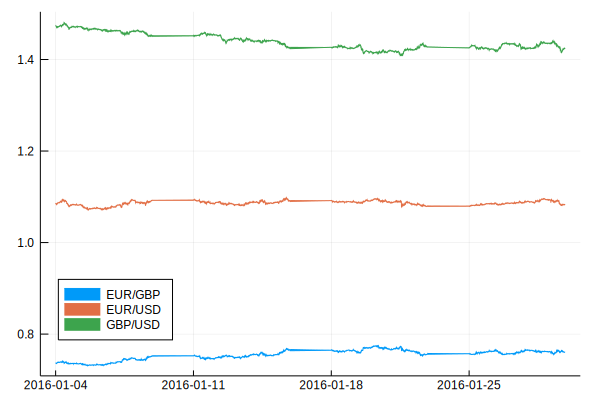

In [73]:
plot_rates(1,Dates.Minute(5)) # January, 5-minute intervals

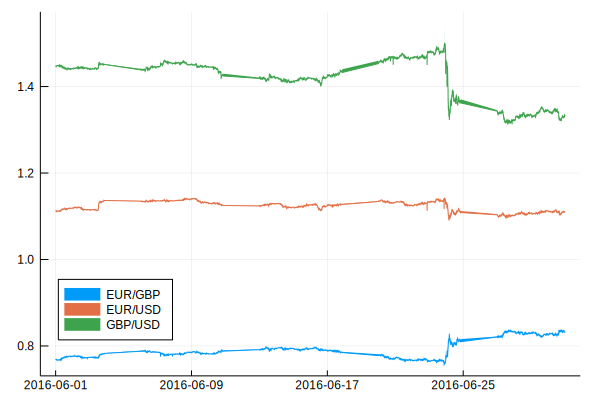

In [74]:
# check out June!
plot_rates(6,Dates.Minute(5))

# Vectorized Aggregation & Summary Statistics


For non-reduction operations, we can use `groupby`:

In [75]:
@everywhere using Statistics

In [76]:
@time groupby(mean, fiveminute_data, (:pair,:timestamp=>Date), select=:bid)

  4.525732 seconds (21.53 M allocations: 727.710 MiB, 7.63% gc time)


2-d Distributed NDSparse with 3898 values (Float32) in 20 chunks:
pair       timestamp  │
──────────────────────┼────────
"AUD/JPY"  2016-01-04 │ 86.0211
"AUD/JPY"  2016-01-05 │ 85.5445
"AUD/JPY"  2016-01-06 │ 84.1173
"AUD/JPY"  2016-01-07 │ 82.8144
"AUD/JPY"  2016-01-08 │ 82.8973
"AUD/JPY"  2016-01-11 │ 82.1244
"AUD/JPY"  2016-01-12 │ 82.2125
"AUD/JPY"  2016-01-13 │ 82.7428
"AUD/JPY"  2016-01-14 │ 82.0008
"AUD/JPY"  2016-01-15 │ 81.1253
"AUD/JPY"  2016-01-18 │ 80.7458
"AUD/JPY"  2016-01-19 │ 81.3649
"AUD/JPY"  2016-01-20 │ 80.3517
"AUD/JPY"  2016-01-21 │ 81.4381
"AUD/JPY"  2016-01-22 │ 82.9526
"AUD/JPY"  2016-01-25 │ 82.8088
"AUD/JPY"  2016-01-26 │ 82.5551
"AUD/JPY"  2016-01-27 │ 83.385
"AUD/JPY"  2016-01-28 │ 83.9863
"AUD/JPY"  2016-01-29 │ 85.5388
"AUD/JPY"  2016-02-01 │ 85.7992
"AUD/JPY"  2016-02-02 │ 85.1527
"AUD/JPY"  2016-02-03 │ 84.2843
"AUD/JPY"  2016-02-04 │ 84.5623
                      ⋮

In [77]:
# Can compute multiple in 1 go
@everywhere begin
    using StatsBase
    p25(x) = StatsBase.quantile(x,0.25f0)
    p50(x) = StatsBase.quantile(x,0.50f0)
    p75(x) = StatsBase.quantile(x,0.75f0)
end
stats = (mean, std, var, p25, p50, p75)
@time groupby(stats, fiveminute_data, (:pair,:timestamp=>Date), select=:bid)

  5.640684 seconds (21.53 M allocations: 729.577 MiB, 4.87% gc time)


2-d Distributed NDSparse with 3898 values (6 field named tuples) in 20 chunks:
pair       timestamp  │ mean     std       var        p25      p50      p75
──────────────────────┼────────────────────────────────────────────────────────
"AUD/JPY"  2016-01-04 │ 86.0211  0.525616  0.276272   85.7055  85.8315  86.1595
"AUD/JPY"  2016-01-05 │ 85.5445  0.419757  0.176196   85.2265  85.3745  85.981
"AUD/JPY"  2016-01-06 │ 84.1173  0.448153  0.200841   83.7598  83.957   84.4185
"AUD/JPY"  2016-01-07 │ 82.8144  0.451442  0.2038     82.4405  82.823   83.1125
"AUD/JPY"  2016-01-08 │ 82.8973  0.556778  0.310002   82.317   83.022   83.4315
"AUD/JPY"  2016-01-11 │ 82.1244  0.388999  0.15132    81.823   82.101   82.4315
"AUD/JPY"  2016-01-12 │ 82.2125  0.242541  0.0588263  82.1177  82.207   82.364
"AUD/JPY"  2016-01-13 │ 82.7428  0.491437  0.24151    82.4658  82.946   83.131
"AUD/JPY"  2016-01-14 │ 82.0008  0.431648  0.18632    81.6147  81.9275  82.4622
"AUD/JPY"  2016-01-15 │ 81.1253  0.821902  0.675

JuliaDB incorporates support for OnlineStats.jl, a library for computing fast statistics using streaming data:

In [78]:
@everywhere using OnlineStats

In [79]:
@time groupreduce(Mean(), fiveminute_data, (:pair,:timestamp=>Date); select = :bid)

  0.058508 seconds (65.49 k allocations: 3.064 MiB)


2-d Distributed NDSparse with 3898 values (Mean{Float64,EqualWeight}) in 80 chunks:
pair       timestamp  │
──────────────────────┼────────────────────────────
"AUD/JPY"  2016-01-04 │ Mean: n=288 | value=86.0211
"AUD/JPY"  2016-01-05 │ Mean: n=288 | value=85.5445
"AUD/JPY"  2016-01-06 │ Mean: n=288 | value=84.1173
"AUD/JPY"  2016-01-07 │ Mean: n=288 | value=82.8144
"AUD/JPY"  2016-01-08 │ Mean: n=264 | value=82.8973
"AUD/JPY"  2016-01-11 │ Mean: n=288 | value=82.1244
"AUD/JPY"  2016-01-12 │ Mean: n=288 | value=82.2125
"AUD/JPY"  2016-01-13 │ Mean: n=288 | value=82.7428
"AUD/JPY"  2016-01-14 │ Mean: n=288 | value=82.0008
"AUD/JPY"  2016-01-15 │ Mean: n=252 | value=81.1253
"AUD/JPY"  2016-01-18 │ Mean: n=288 | value=80.7458
"AUD/JPY"  2016-01-19 │ Mean: n=288 | value=81.3649
"AUD/JPY"  2016-01-20 │ Mean: n=288 | value=80.3517
"AUD/JPY"  2016-01-21 │ Mean: n=288 | value=81.4381
"AUD/JPY"  2016-01-22 │ Mean: n=252 | value=82.9526
"AUD/JPY"  2016-01-25 │ Mean: n=288 | value=82.8088
"AUD/JPY

Can compute multiple statistics in one go using `Series`:

In [80]:
@time sumdata = groupreduce(Series(Mean(),Variance(),Quantile()), fiveminute_data, (:pair,:timestamp=>Date); select = :bid)

  0.082337 seconds (73.74 k allocations: 3.544 MiB)


2-d Distributed NDSparse with 3898 values (Series{Number,Tuple{Mean{Float64,EqualWeight},Variance{Float64,EqualWeight},Quantile{OMAS,LearningRate}}}) in 80 chunks:
    Dimensions#  colname    type
────────────────────
1  pair       String
2  timestamp  Date
    ValuesSeries{Number,Tuple{Mean{Float64,EqualWeight},Variance{Float64,EqualWeight},Quantile{OMAS,LearningRate}}}

Use `value` to extract the value from OnlineStat objects:

In [81]:
map(value, sumdata)

2-d Distributed NDSparse with 3898 values (3-tuples) in 80 chunks:
pair       timestamp  │ 3        4          5
──────────────────────┼────────────────────────────────────────────────
"AUD/JPY"  2016-01-04 │ 86.0211  0.276272   [85.6905, 85.7363, 85.7449]
"AUD/JPY"  2016-01-05 │ 85.5445  0.176196   [85.1153, 85.1804, 85.2797]
"AUD/JPY"  2016-01-06 │ 84.1173  0.200841   [83.7674, 83.7703, 83.9226]
"AUD/JPY"  2016-01-07 │ 82.8144  0.2038     [82.4194, 82.528, 82.7617]
"AUD/JPY"  2016-01-08 │ 82.8973  0.310002   [82.1408, 82.1944, 82.5307]
"AUD/JPY"  2016-01-11 │ 82.1244  0.151321   [82.0387, 82.4543, 82.3808]
"AUD/JPY"  2016-01-12 │ 82.2125  0.0588263  [82.1935, 82.2629, 82.3317]
"AUD/JPY"  2016-01-13 │ 82.7428  0.24151    [82.408, 82.1441, 82.6577]
"AUD/JPY"  2016-01-14 │ 82.0008  0.18632    [82.2234, 82.5035, 82.5395]
"AUD/JPY"  2016-01-15 │ 81.1253  0.675523   [80.3092, 80.5146, 80.4131]
"AUD/JPY"  2016-01-18 │ 80.7458  0.0420077  [80.6123, 80.5673, 80.6666]
"AUD/JPY"  2016-01-19 │ 8

In [82]:
@time sumdata_all = groupreduce(Series(Mean(),Variance(),Quantile()), data, (:pair,:timestamp=>Date); select = :bid)

 31.993802 seconds (70.13 k allocations: 3.458 MiB, 0.06% gc time)


2-d Distributed NDSparse with 3898 values (Series{Number,Tuple{Mean{Float64,EqualWeight},Variance{Float64,EqualWeight},Quantile{OMAS,LearningRate}}}) in 80 chunks:
    Dimensions#  colname    type
────────────────────
1  pair       String
2  timestamp  Date
    ValuesSeries{Number,Tuple{Mean{Float64,EqualWeight},Variance{Float64,EqualWeight},Quantile{OMAS,LearningRate}}}

# Arbitrage using JuMP

An important advantage of JuliaDB over other time-series databases is that it lets you leverage the whole ecosystem of Julia packages. This composability is very powerful. Here's an example where we apply the state-of-the-art JuMP linear programming library on our data to determine arbitrage.


This example [example](http://mattmcd.github.io/2013/03/30/FX-Arbitrage-CLP.html) is taken from ["Optimization in Finance" by Cornuejols and Tutuncu](https://www.amazon.co.uk/Optimization-Methods-Finance-Mathematics-Risk/dp/0521861705)

In [83]:
@everywhere using JuMP, GLPK, GLPKMathProgInterface

Below is our constraint programming function. Given currency conversion rates of 6 pairs of currencies, it will return the amount of currency to transact for each possible conversion. The objective is to make $100 in every five minute window!

In [84]:
@everywhere function fx_arbitrage(eurusd, eurgbp, eurjpy, gbpusd, gbpjpy, usdjpy)

    usdeur = 1.0/eurusd
    usdgbp = 1.0/gbpusd
    gbpeur = 1.0/eurgbp
    jpyusd = 1.0/usdjpy
    jpyeur = 1.0/eurjpy
    jpygbp = 1.0/gbpjpy

    m = JuMP.Model(solver = GLPKMathProgInterface.GLPKSolverLP(msg_lev = GLPK.MSG_ERR))

    JuMP.@variables m begin
        de; dp; dy; ed; ep; ey; pd; pe; py; yd; ye; yp; profit
    end

    JuMP.@objective(m, Max, profit)

    JuMP.@constraints(m, begin
        0 <= de <= 100
        0 <= dp <= 100
        0 <= dy <= 100
        0 <= ed <= 100
        0 <= ep <= 100
        0 <= ey <= 100
        0 <= pd <= 100
        0 <= pe <= 100
        0 <= py <= 100
        0 <= yd <= 100
        0 <= ye <= 100
        0 <= yp <= 100
        de + dp + dy - eurusd*ed - gbpusd*pd - jpyusd*yd == profit
        ed + ep + ey - usdeur*de - gbpeur*pe - jpyeur*ye == 0.0
        pd + pe + py - usdgbp*dp - eurgbp*ep - jpygbp*yp == 0.0
        yd + ye + yp - usdjpy*dy - eurjpy*ey - gbpjpy*py == 0.0
    end)

    JuMP.solve(m)

    JuMP.getvalue(profit)
end

We can take out columns from a Distributed table, and the column itself will be a distributed array.

In [85]:
getbids(t) = values(t, :bid)
bidscol = getbids(fiveminute_data)

Dagger.DArray{Float32,1,typeof(JuliaDB.dvcat)}(1096697,)

In [86]:
length(chunks(bidscol)) # same number of chunks as the data! Again this is a lazy view.

80

In [87]:
@time sum(bidscol) # just for kicks

  0.013716 seconds (19.63 k allocations: 949.813 KiB)


4.817453f7

In [88]:
t_5m  = DateTime(2016,6,1):Dates.Minute(5):DateTime(2016,7,1)

# Arbitrage example
inds = keys(fiveminute_data["EUR/USD",t_5m], :timestamp) |> collect
eurusd = fiveminute_data["EUR/USD",t_5m] |> getbids
eurgbp = fiveminute_data["EUR/GBP",t_5m] |> getbids
eurjpy = fiveminute_data["EUR/JPY",t_5m] |> getbids
gbpusd = fiveminute_data["GBP/USD",t_5m] |> getbids
gbpjpy = fiveminute_data["GBP/JPY",t_5m] |> getbids
usdjpy = fiveminute_data["USD/JPY",t_5m] |> getbids

arbitrage_profit = map(fx_arbitrage, map(collect, (eurusd, eurgbp, eurjpy, gbpusd, gbpjpy, usdjpy))...)

6191-element Array{Float64,1}:
 0.0007537094654708199
 0.0023719235812080797
 0.014636902877654734 
 0.04926458678171741  
 0.01244578481502856  
 0.009105181805722395 
 0.04343290322292148  
 0.021099234984802706 
 0.011945250517257477 
 0.04280524992142887  
 0.006251190819199337 
 0.021894287231361886 
 0.04245281987874705  
 ⋮                    
 0.060281640386619983 
 0.014038058649191498 
 0.052395721417852315 
 0.01694989428276017  
 0.008551653148231253 
 0.034352540687393684 
 0.010181195398686782 
 0.022109103059761992 
 0.008401083373911433 
 0.11072383688284049  
 0.02369899521799823  
 0.046274358646059    

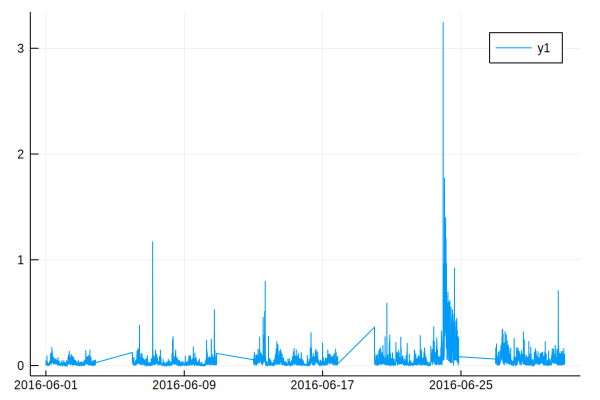

In [89]:
plot(inds, arbitrage_profit )